In [10]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Libraries for reading, cleaning and plotting the dataa
import numpy as np 
import pandas as pd 
import csv
import matplotlib.pyplot as plt


# Libraries for models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier

In [21]:
# Read in training data 
training_data = []
with open('data/train.csv', newline='') as csvfile:
    train_data = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in train_data:
        training_data.append(row)
            
# Convert to a numpy array of type int (except for the label row)
training_data = np.array(training_data[1:]).astype(int)   

# Read in test data
testing_data = []
with open('data/test.csv', newline='') as csvfile:
    test_data = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in test_data:
        testing_data.append(row)

# The testing file is huge so only read in max_test_data
max_test_data = 30001
test_data = np.array(testing_data[1:max_test_data]).astype(int)        

In [32]:
# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(training_data.shape[0]))
training_data = training_data[shuffle]

# Split training data (labeled) into 80% training and 20% dev) and skip over the id column (it doesn't add an information)
# Immediately cast train data as floats so we can normalize it later 
split_index = int(len(training_data) * 0.8)
train_data = training_data[:split_index, 1:-1].astype(np.float64)
train_labels = training_data[:split_index, -1]
dev_data = training_data[split_index:, 1:-1].astype(np.float64)
dev_labels = training_data[split_index:, -1]
test_data = test_data[:,1:]

# Retrieve the mean and standard deviation of each feature - axis=0 is for going along the columns, keepdims forces the dimensions to stay the same
# Only compute it for the first ten features (they're numeric - not one hot or categorical)
num_columns = 10
# To avoid dividing by 0, add 1e-10 to the standard deviation 
smoothing = 1e-10
feature_mean = train_data[:,:num_columns].mean(axis=0, keepdims=True)
feature_std = train_data[:,:num_columns].std(axis=0, keepdims=True)
# Scale all numeric features to have a zero mean and unit variance
train_data[:,:num_columns] =  preprocessing.scale(train_data[:,:num_columns], axis=0)
# Normalize and scale dev data as well (using training mean and standard deviation)
dev_data[:,:num_columns] = dev_data[:,:num_columns] - feature_mean
dev_data[:,:num_columns] = dev_data[:,:num_columns]/(feature_std + smoothing)

In [38]:
# Explore and confirm the shape of the data
print("Training data shape: {0} Training labels shape: {1}".format(train_data.shape, train_labels.shape))
print("Dev data shape: {0} Dev labels shape: {1}".format(train_data.shape, train_labels.shape))
print("Test data shape: ", test_data.shape)
print("First training example: ", train_data[0,:10], train_labels [0])
print("First dev example: ", dev_data[0,:10], dev_labels [0])
print("First test example: ", test_data[0])

Training data shape: (12096, 54) Training labels shape: (12096,)
Dev data shape: (12096, 54) Dev labels shape: (12096,)
Test data shape:  (30000, 52)
First training example:  [-0.97516312  0.06119537 -0.76971586 -1.07786212 -0.83196557 -1.16383734
  0.53282308  1.05937509  0.2346274  -1.17998782] 6
First dev example:  [-1.45489799 -1.12656445  1.59942409  0.15085482  1.3166273  -0.95540139
 -0.40931373 -2.55909699 -1.20557665 -0.95023786] 3
First test example:  [  14    0    0 2684  196  214  156 6645    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    1    0
    0    0    0    0    0    0    0    0    0    0]


Random Forest Performance for 1 trees: 0.5307539682539683
Random Forest Confusion Matrix:

[[ 90  39   0   0   8   0  17]
 [ 65 112   4   0  28   2   3]
 [ 38  65 230  20  70 125  25]
 [  0   0  60 394   0  53   0]
 [ 65  93  18   4 222  23  13]
 [  1  13  95  15   8 203   0]
 [179 111  26   0 109  24 354]]



Random Forest Performance for 3 trees: 0.6263227513227513
Random Forest Confusion Matrix:

[[245 147   7   0  40   2  53]
 [ 35 119   0   0  19   2  11]
 [  0   9 289  64  13 157   0]
 [  0   3  37 346   2  39   0]
 [111 128  11   0 352  12  23]
 [  5  19  89  23  19 218   0]
 [ 42   8   0   0   0   0 325]]



Random Forest Performance for 5 trees: 0.6775793650793651
Random Forest Confusion Matrix:

[[199  77   0   0   2   0  38]
 [ 94 206   3   0  52   3   0]
 [  0  10 272  15  19 101   0]
 [  0   0  47 408   0  50   0]
 [ 70 101  24   0 356  35   5]
 [ 11  26  87  10  15 240   1]
 [ 64  13   0   0   1   1 368]]



Random Forest Performance for 10 trees: 0.7156084656084656
Rando

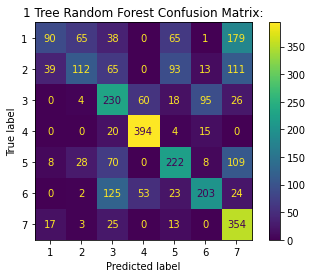

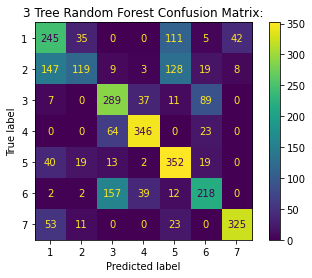

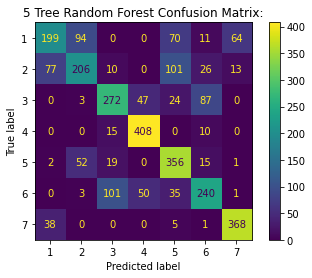

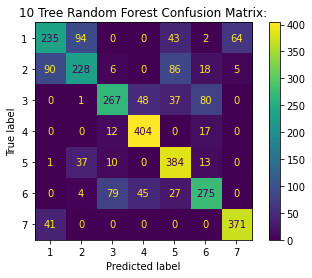

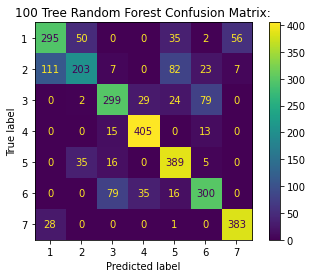

In [34]:
# Try a random forest - before any data cleaning 
def RandomForest(num_trees):
    model = RandomForestClassifier(num_trees,max_depth=8)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("Random Forest Performance for {0} trees: {1}".format(num_trees,score))
    print("Random Forest Confusion Matrix:\n")
    print(confusion_matrix(predictions, dev_labels))
    
    #plot_confusion_matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("{} Tree Random Forest Confusion Matrix:".format(num_trees))
    plt.plot()
    print('\n\n')
    
num_trees_list = [1,3,5,10,100]
for num_trees in num_trees_list:
    RandomForest(num_trees)

BernoulliNB for alph = 0.01: accuracy = 0.6107804232804233





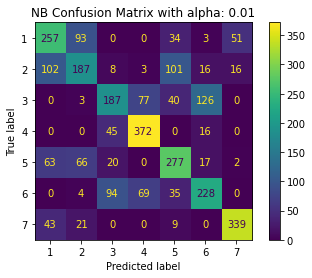

In [35]:
# Try Naive Bayes - before any data cleaning 
def NB(alf):
    model = BernoulliNB(alpha = alf)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("BernoulliNB for alph = {0}: accuracy = {1}".format(alf,score))
    
    #plot_confusion_matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("NB Confusion Matrix with alpha: {}".format(alf))
    plt.plot()
    print('\n\n')
    
# the alpha isn't actually making a difference 
# alphas_list = [0.00001,0.001, 0.01, 0.1, 1, 10]
alphas_list = [0.01]
for alpha in alphas_list:
    NB(alpha)

KNN 1 neighbors : accuracy = 0.7936507936507936



KNN 2 neighbors : accuracy = 0.7708333333333334



KNN 4 neighbors : accuracy = 0.7791005291005291



KNN 7 neighbors : accuracy = 0.7619047619047619



KNN 10 neighbors : accuracy = 0.7529761904761905





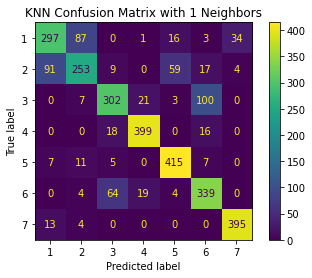

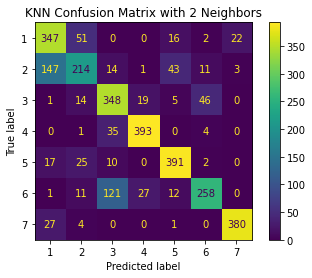

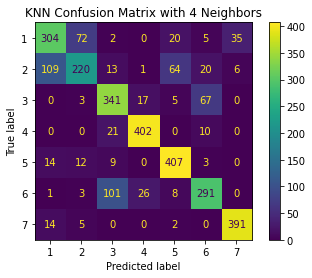

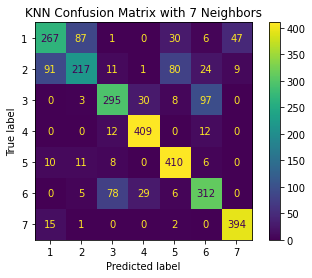

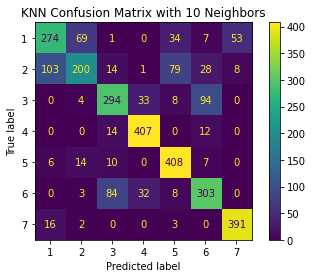

In [36]:
# Try K Nearest Neighbors - before any data cleaning 
def KNN(kn):
    model = KNeighborsClassifier(n_neighbors = kn)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("KNN {0} neighbors : accuracy = {1}".format(kn,score))
    
    #plot_confusion_matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("KNN Confusion Matrix with {} Neighbors".format(kn))
    plt.plot()
    print('\n\n')
    
# the alpha isn't actually making a difference 
neigh_list = [1,2,4, 7, 10]
# neigh_list = [5]
for neigh in neigh_list:
    KNN(neigh)

In [37]:
# Try Multi-Layer Perceptron - before any data cleaning 
def MLP():
#    model = MLPClassifier(solver='adam', alpha=1e-6, hidden_layer_sizes=(100, ), random_state=0) .8257
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0)  .82969
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(200, ), random_state=0) .837
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0, activation='tanh') .83068

    # Default activation is 'relu', random state lets us get the same result every time (so we can tune other parameters)
    # max_iter is 200 by default, but more helps. alpha is the regularization parameter. solver is 'adam' by default
    model = MLPClassifier(alpha=1e-3, hidden_layer_sizes=(200,), random_state=0, max_iter=300) #.8409
    model.fit(train_data, train_labels) 
    score = model.score(dev_data, dev_labels)
    print("MLP accuracy = ",score)

    
MLP()

MLP accuracy =  0.8409391534391535


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### End matter

#### Acknowledgements/Sources

* That helpful stack overflow post
  * the url for it
* Relevant Documentation
  * KNeighborsClassifier
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  * Pretty Confusion Matrix
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
  * Preprocessing
    * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
* Soil information
  * https://www.uidaho.edu/cals/soil-orders/aridisols
  
#### Backup Formats

*because sometimes you just want to look at the markdown or whatever real quick*

In [8]:
#Create a backup of the jupyter notebook in a format for where changes are easier to see.
!jupyter nbconvert clear-cut-solution.ipynb --to="python" --output="backups/clear-cut-solution"
!jupyter nbconvert clear-cut-solution.ipynb --to markdown --output="backups/clear-cut-solution"

# Also archiving this bad boy
!jupyter nbconvert clear-cut-solution.ipynb --to html --output="backups/clear-cut-solution"

[NbConvertApp] Converting notebook clear-cut-solution.ipynb to python
[NbConvertApp] Writing 6893 bytes to backups/clear-cut-solution.py
[NbConvertApp] Converting notebook clear-cut-solution.ipynb to markdown
[NbConvertApp] Support files will be in backups/clear-cut-solution_files/
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_f